In [95]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from torch import Tensor

from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.129'

In [96]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [97]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Load the data

In [98]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 87554), Heartdataset (len 21892))

Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


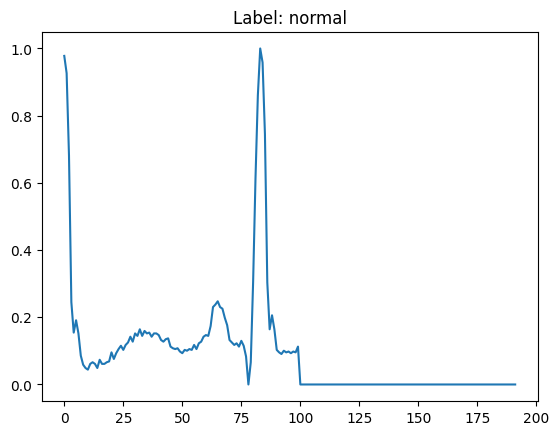

In [99]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [100]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

Positional encoding to use with the transformer.

In [101]:
# from torch import Tensor
# import math

# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_seq_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(1, max_seq_len, d_model)
#         # batch, seq_len, d_model
#         pe[0, :, 0::2] = torch.sin(position * div_term)
#         pe[0, :, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Arguments:
#             x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
#         """
#         x = x + self.pe[:, :x.size(1), :]
#         return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [102]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, config: dict):
        super(GRUModel, self).__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.gru = nn.GRU(
            input_size=config["hidden"],
            hidden_size=config["hidden"],
            num_layers=config.get("num_layers", 1),
            batch_first=True,
            dropout=config.get("dropout", 0.0),
        )
        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x):
        x = self.conv1d(x.transpose(1, 2))  # (batch, seq_len, channels) -> (batch, channels, seq_len)
        x = x.transpose(1, 2)  # (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.gru(x)  # Apply GRU
        x = x.mean(dim=1)  # Global Average Pooling
        x = self.out(x)
        return x


In [103]:
from src import models

config = {
    "input_size": 1,  
    "hidden": 32,
    "dropout": 0.1,
    "output": 5,
    "num_layers": 3,  # Voeg ook num_layers toe als dat nodig is
}

model = models.GRU(config)


In [104]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [105]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [106]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("GRU")

<Experiment: artifact_location='/Users/rubengoedings/Documents/Ru_hu_ML_exam/notebooks/mlruns/3', creation_time=1736951576001, experiment_id='3', last_update_time=1736951576001, lifecycle_stage='active', name='GRU', tags={}>

In [107]:
len(trainstreamer) // 5

547

In [108]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "GRU")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-21 11:19:27.711 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250121-111927
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 547/547 [00:27<00:00, 19.68it/s]
2025-01-21 11:19:58.423 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6831 test 0.6498 metric ['0.8281', '0.8281', '0.2791', '0.8281', '0.3065']
100%|██████████| 547/547 [00:28<00:00, 19.29it/s]
2025-01-21 11:20:29.910 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5945 test 0.4479 metric ['0.8752', '0.8752', '0.4427', '0.8752', '0.4818']
100%|██████████| 547/547 [00:29<00:00, 18.42it/s]
2025-01-21 11:21:02.716 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3935 test 0.3754 metric ['0.8994', '0.8994', '0.5718', '0.8994', '0.5834']
100%|██████████| 547/547 [00:29<00:00, 18.28it/s]
2025-01-21 11:21:35.892 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3357 test 0.3142 metric ['0.9184', '0.9184', '0.6578', '0.9184', '0.6813']
100%|██████████| 547/547 [00:31<00:00, 17.63it/s]
2025-01-21 11:22:10.175 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.3117 test 0.2965 metric ['0.91

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

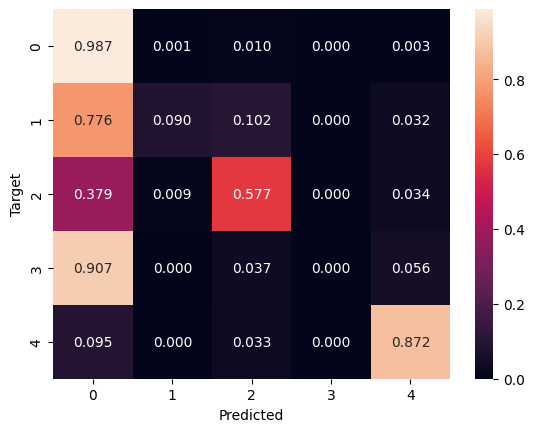

In [109]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) 
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")